## Experiment Setup

1. 1 client node and 8 server nodes are all the same machine type:

   **c220g2**    Haswell, 20 core, 3 disks
   
    ---
    ```
    CPU       Two Intel E5-2660 v3 10-core CPUs at 2.60 GHz (Haswell EP)
    RAM       160GB ECC Memory (10x 16 GB DDR4 2133 MHz dual rank RDIMMs)
    Disk      One Intel DC S3500 480 GB 6G SATA SSDs
    Disk      Two 1.2 TB 10K RPM 6G SAS SFF HDDs
    NIC       Dual-port Intel X520 10Gb NIC (PCIe v3.0, 8 lanes
    NIC       Onboard Intel i350 1Gb
    ```
    ---

1. The isolated experiment network used in the experiment is 10Gb/s

1. The data file is stored in the SSD.

1. Servers send data and client receives data.

1. The hight of every single bar represents the total CPU cycle consumption on both client and all the involved servers.

1. The numbers of bitrate in the graphs are measured on the client (the receiver).

1. Each bin related to the number of servers consists of two sub-bins. The data of left sub-bin comes from filtering the data by the client, while the data of right sub-bin comes from filtering the data by the servers.

1. The data filtering method used in this experiment is `linspace` with `step=2`, which means it reads/receives all the data but only selects those even index bytes for next processing. For example,
    - The server reads sequentially from the local data file, but only selects the bytes at index `0, 2, 4, ...` to send to the network.
    - The client receives all the data from the bound network interface, but only select the bytes at index `0, 2, 4, ...` to be cached in the memory.

1. The client always keeps the latest filtered data up to 500MB in the memory.

1. Each server reads as well as filters the data in only one thread.

1. The number of processes used in the client depends on the number of servers it connects to in a test. For example, when the client receives data from 3 servers, it starts 3 processes one for each connection in order for parallelly receiving. Each started process runs only one thread.

1. The benchmark tool is [Pyben-nio](https://github.com/ljishen/pyben-nio/)

1. The number of CPU cycles is reported by [perf stat](http://man7.org/linux/man-pages/man1/perf-stat.1.html)

In [1]:
from IPython.display import display, Markdown

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

In [2]:
_AVG = 'avg'
_STD = 'std'

def gen_df(json_file):
    FILE_PATH = '../backups/pyben-nio/' + json_file
    
    with open(FILE_PATH, 'r') as fobj:
        df = pd.read_json(fobj)

    for size in df.columns:
        size_df = df[size]

        for nservs in size_df.index:
            nservs_df = size_df[nservs]

            client_bitrates = nservs_df['bitrate']['client']
            nservs_df['bitrate']['client'] = \
                {_AVG: np.mean(client_bitrates), _STD: np.std(client_bitrates, ddof=1)}

            client_cycles = nservs_df['cycles']['client']
            nservs_df['cycles']['client'] = \
                {_AVG: np.mean(client_cycles), _STD: np.std(client_cycles, ddof=1)}

            servers_bitrates = []
            servers_cycles = []
            for serv_idx in range(nservs):
                bitrates = [arr[serv_idx] for arr in nservs_df['bitrate']['servers']]
                servers_bitrates.append(
                    {_AVG: np.mean(bitrates), _STD: np.std(bitrates, ddof=1)})

                cycles = [arr[serv_idx] for arr in nservs_df['cycles']['servers']]
                servers_cycles.append(
                    {_AVG: np.mean(cycles), _STD: np.std(cycles, ddof=1)})

            nservs_df['bitrate']['servers'] = servers_bitrates
            nservs_df['cycles']['servers'] = servers_cycles
            
    return df

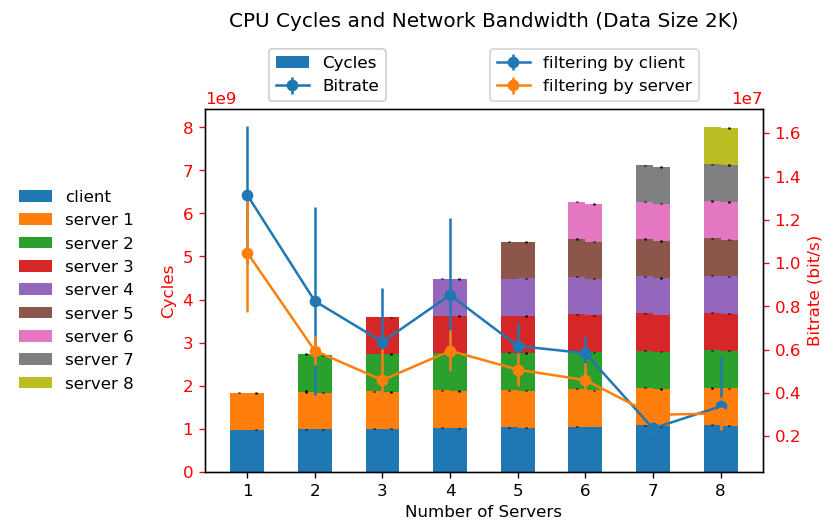

---

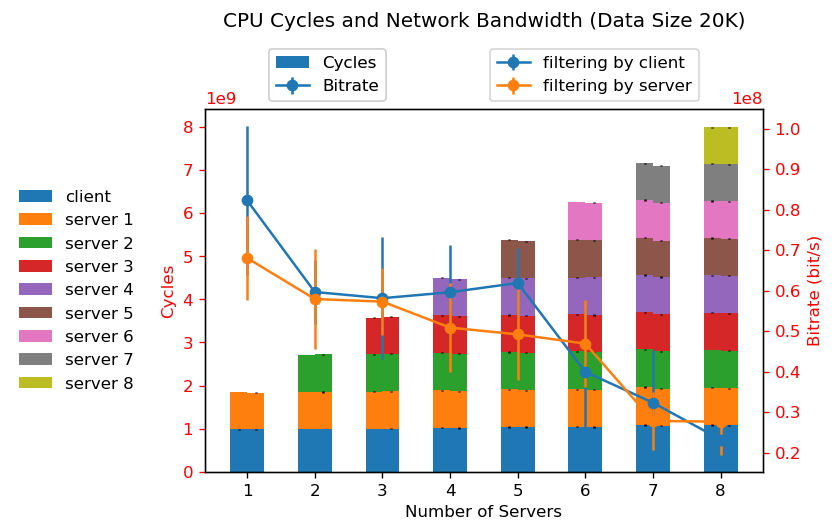

---

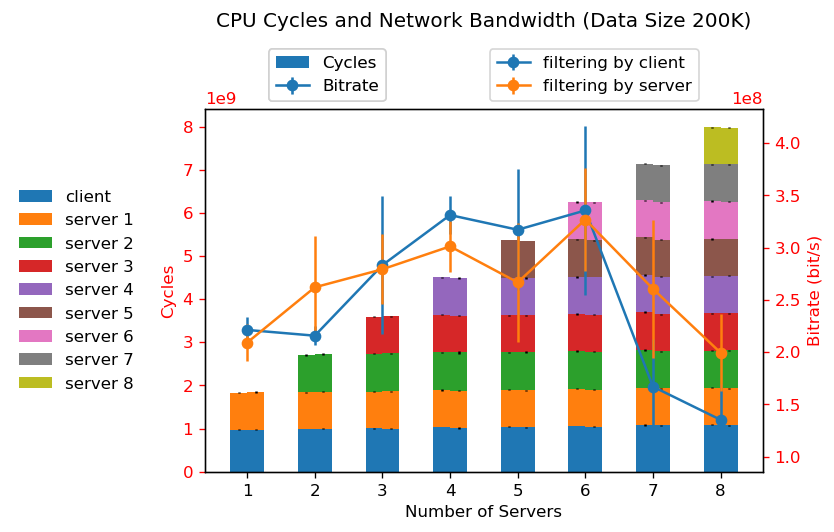

---

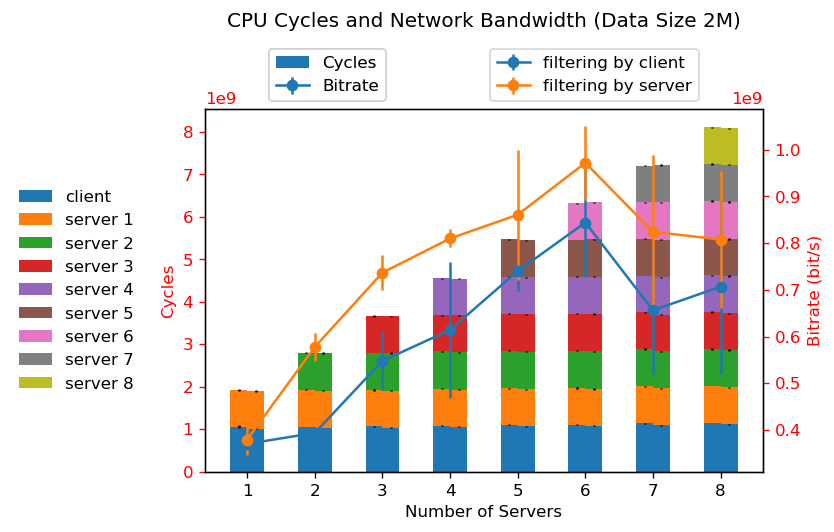

---

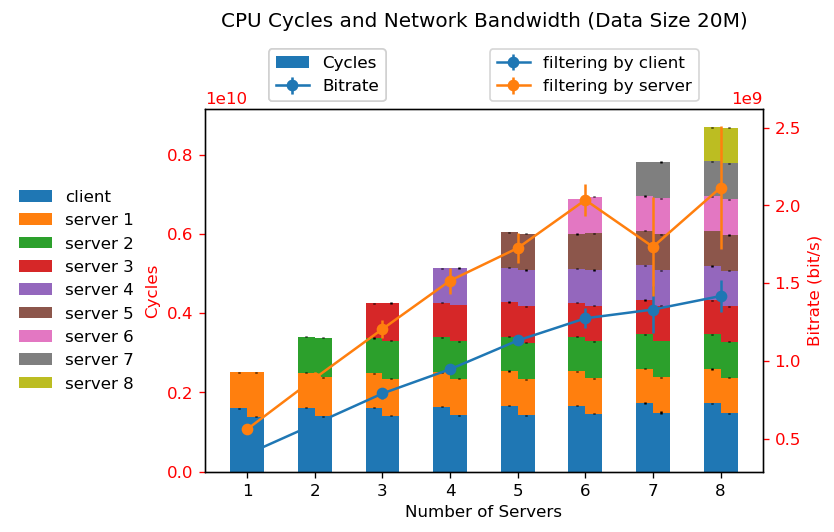

---

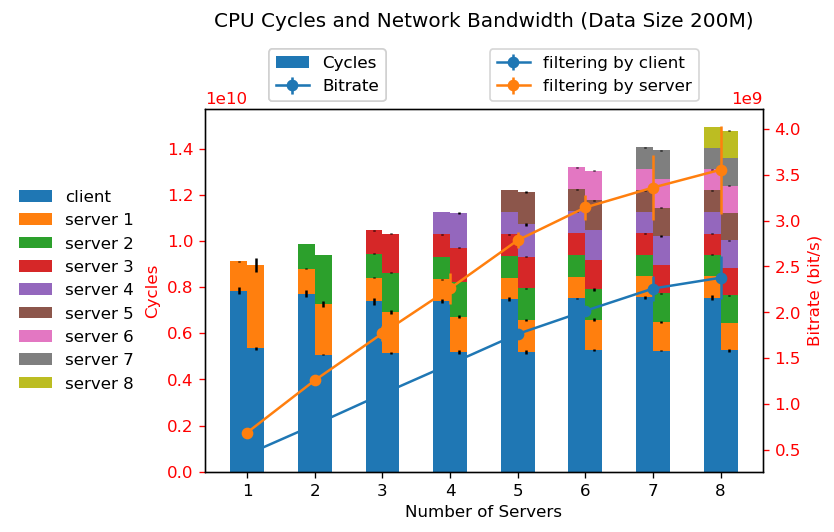

---

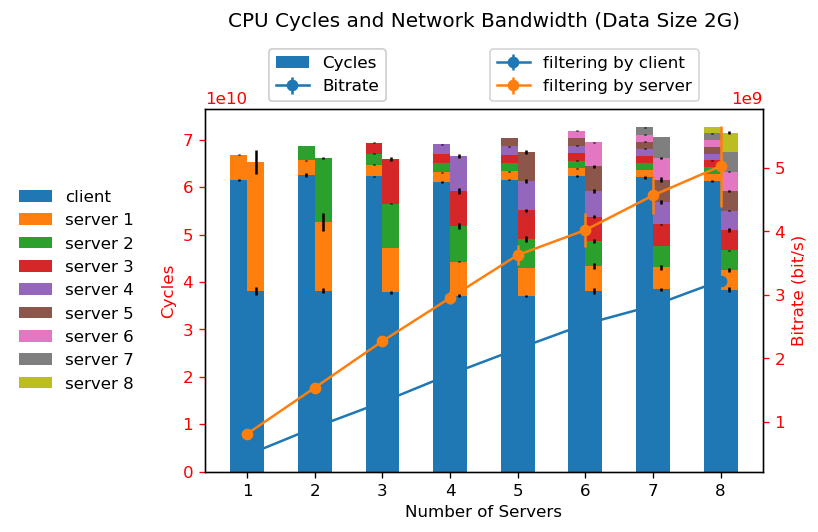

---

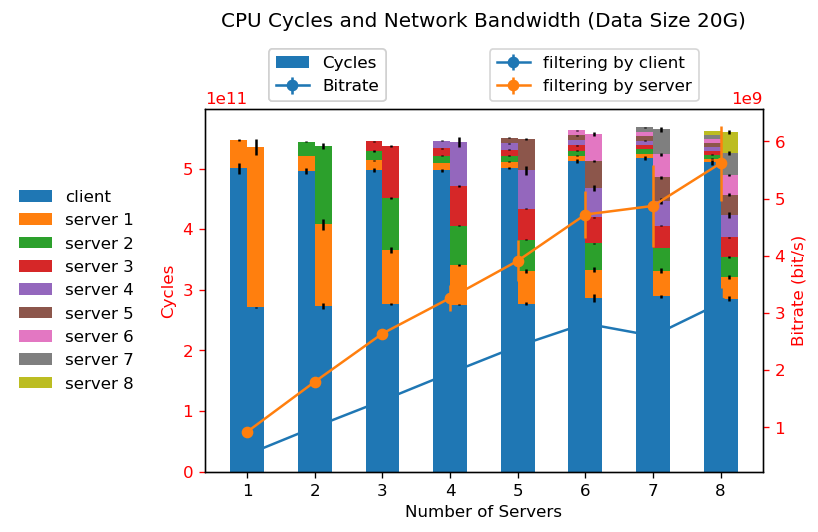

---

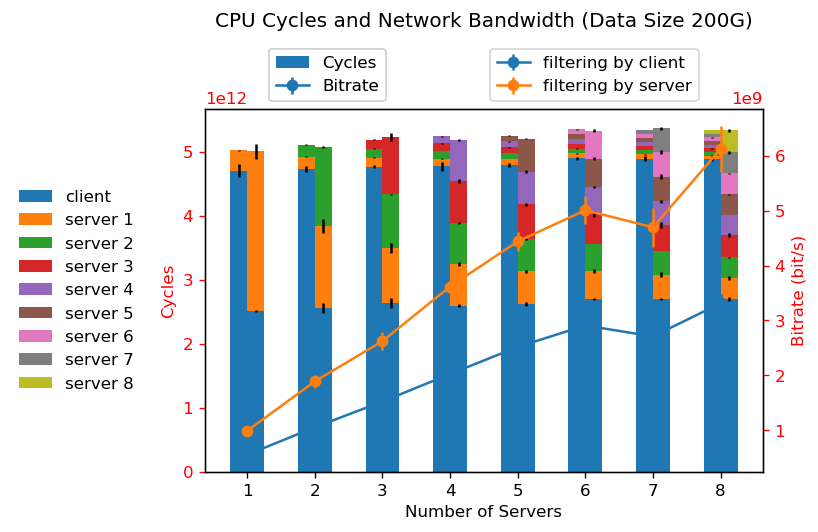

---

In [3]:
FILE_PATH_SERVERS_FILTERING = 'output_servers_linspace_2_8servs/result.json'
FILE_PATH_CLIENT_FILTERING = 'output_client_linspace_2_8servs/result.json'

df_server_filtering = gen_df(FILE_PATH_SERVERS_FILTERING)
df_client_filtering = gen_df(FILE_PATH_CLIENT_FILTERING)

N = len(df_client_filtering.index)
FILTERING_STEP = 2
ind = np.arange(N)                  # the x locations for the groups
width = 1 / (FILTERING_STEP + 2)    # the width of the bars
yax_clr = 'r'


def __human2kbytes(string):
    num = int(''.join(filter(str.isdigit, string)))
    if string.endswith('K'):
        return num
    elif string.endswith('M'):
        return num << 10
    else:
        return num << 20
    
    
def __plot_client_cycles(ax, size_df, offsets, **kwargs):
    cycle_avgs = [size_df[nservs]['cycles']['client'][_AVG] for nservs in size_df.index]
    cycle_stds = [size_df[nservs]['cycles']['client'][_STD] for nservs in size_df.index]
    return cycle_avgs, ax.bar(offsets, cycle_avgs, width, yerr=cycle_stds, **kwargs)


def __plot_server_cycles(ax, size_df, serv_idx, offsets, bottom, **kwargs):
    server_cycle_avgs = []
    server_cycle_stds = []

    for nservs in size_df.index:
        server_cycle_arr = size_df[nservs]['cycles']['servers']
        cycle_avg = 0
        cycle_std = 0

        if len(server_cycle_arr) - 1 >= serv_idx:
            cycle_avg = server_cycle_arr[serv_idx][_AVG]
            cycle_std = server_cycle_arr[serv_idx][_STD]

        server_cycle_avgs.append(cycle_avg)
        server_cycle_stds.append(cycle_std)

    bar = ax.bar(offsets, server_cycle_avgs, width,
             bottom=bottom, yerr=server_cycle_stds, **kwargs)
    
    return np.sum([bottom, server_cycle_avgs], axis=0), bar


def __plot_client_bitrate(ax, offset, size_df):
    return ax.errorbar(
        offset,
        [size_df[nservs]['bitrate']['client'][_AVG] for nservs in size_df.index],
        yerr=[size_df[nservs]['bitrate']['client'][_STD] for nservs in size_df.index],
        fmt='-o')


columns_client_filtering = sorted(df_client_filtering.columns, key=__human2kbytes)
columns_server_filtering = sorted(df_server_filtering.columns, key=__human2kbytes)

for size_idx in range(len(columns_client_filtering)):
    fig, ax1 = plt.subplots()
    
    # Change the size of figure
    # See https://stackoverflow.com/a/4306340
    fig.set_dpi(120)
    
    size_df_client = df_client_filtering[columns_client_filtering[size_idx]]
    size_df_server = df_server_filtering[columns_server_filtering[size_idx]]
    
    # Draw bins for Cycles
    cycle_bars = []
    
    ## Plot client cycles for client filtering
    client_cycle_avgs, bar = __plot_client_cycles(
        ax1,
        size_df_client,
        ind)
    cycle_bars.append(bar)
    
    ## Plot client cycles for server filtering
    server_cycle_avgs, bar = __plot_client_cycles(
        ax1,
        size_df_server,
        ind + width,
        color=bar.patches[0].get_facecolor())
    
    
    ## Plot server cycles
    last_bottom_client = client_cycle_avgs
    last_bottom_server = server_cycle_avgs
    for serv_idx in range(N):
        ## Plot server cycles for client filtering
        last_bottom_client, bar = \
            __plot_server_cycles(
                ax1,
                size_df_client,
                serv_idx,
                ind,
                last_bottom_client)
        cycle_bars.append(bar)
        
        ## Plot server cycles for server filtering
        last_bottom_server, bar = \
            __plot_server_cycles(
                ax1,
                size_df_server,
                serv_idx,
                ind + width,
                last_bottom_server,
                color=bar.patches[0].get_facecolor())        
        
    ax1.set_ylabel('Cycles', color=yax_clr)
    ax1.tick_params('y', colors=yax_clr)
    ax1.set_xlabel('Number of Servers')

    plt.legend(
        cycle_bars,
        ['client'] + ['server ' + str(idx) for idx in size_df_client.index],
        loc=5,
        bbox_to_anchor=(-0.1, 0.5),
        frameon=False)
    
    
    # Draw lines for Bitrate
    ax2 = ax1.twinx()

    bitrate_bars = []
    bitrate_bars.append(__plot_client_bitrate(ax2, ind + width / 2, size_df_client))
    bitrate_bars.append(__plot_client_bitrate(ax2, ind + width / 2, size_df_server))

    ax2.set_ylabel('Bitrate (bit/s)', color=yax_clr)
    ax2.tick_params('y', colors=yax_clr)
    
    plt.gca().add_artist(plt.legend(
        bitrate_bars,
        ['filtering by client', 'filtering by server'],
        loc=4,
        bbox_to_anchor=(0.9, 1)))

    plt.gca().add_artist(plt.legend(
        [cycle_bars[0], bitrate_bars[0]],
        ['Cycles', 'Bitrate'],
        loc=3,
        bbox_to_anchor=(0.1, 1)))
    
    plt.xticks(ind + width / 2, size_df_client.index)
    plt.title('CPU Cycles and Network Bandwidth (Data Size ' +
              columns_client_filtering[size_idx] + ')', y=1.2)

    plt.show()
    display(Markdown('---'))